## Docugami RAG over XML Knowledge Graphs (KG-RAG)

Many documents contain a mixture of content types, including text and tables. 

Semi-structured data can be challenging for conventional RAG for a few reasons since semantics may be lost by text-only chunking techniques, e.g.: 

* Text splitting may break up tables, corrupting the data in retrieval
* Embedding tables may pose challenges for semantic similarity search 

Docugami deconstructs documents into XML Knowledge Graphs consisting of hierarchical semantic chunks using the XML data model. This cookbook shows how to perform RAG using XML Knowledge Graphs as input (**KG-RAG**):

* We will use [Docugami](http://docugami.com/) to segment out text and table chunks from documents (PDF \[scanned or digital\], DOC or DOCX) including semantic XML markup in the chunks.
* We will use the [multi-vector retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) to store raw tables and text (including semantic XML markup) along with table summaries better suited for retrieval.
* We will use [LCEL](https://python.langchain.com/docs/expression_language/) to implement the chains used.

The overall flow is here:

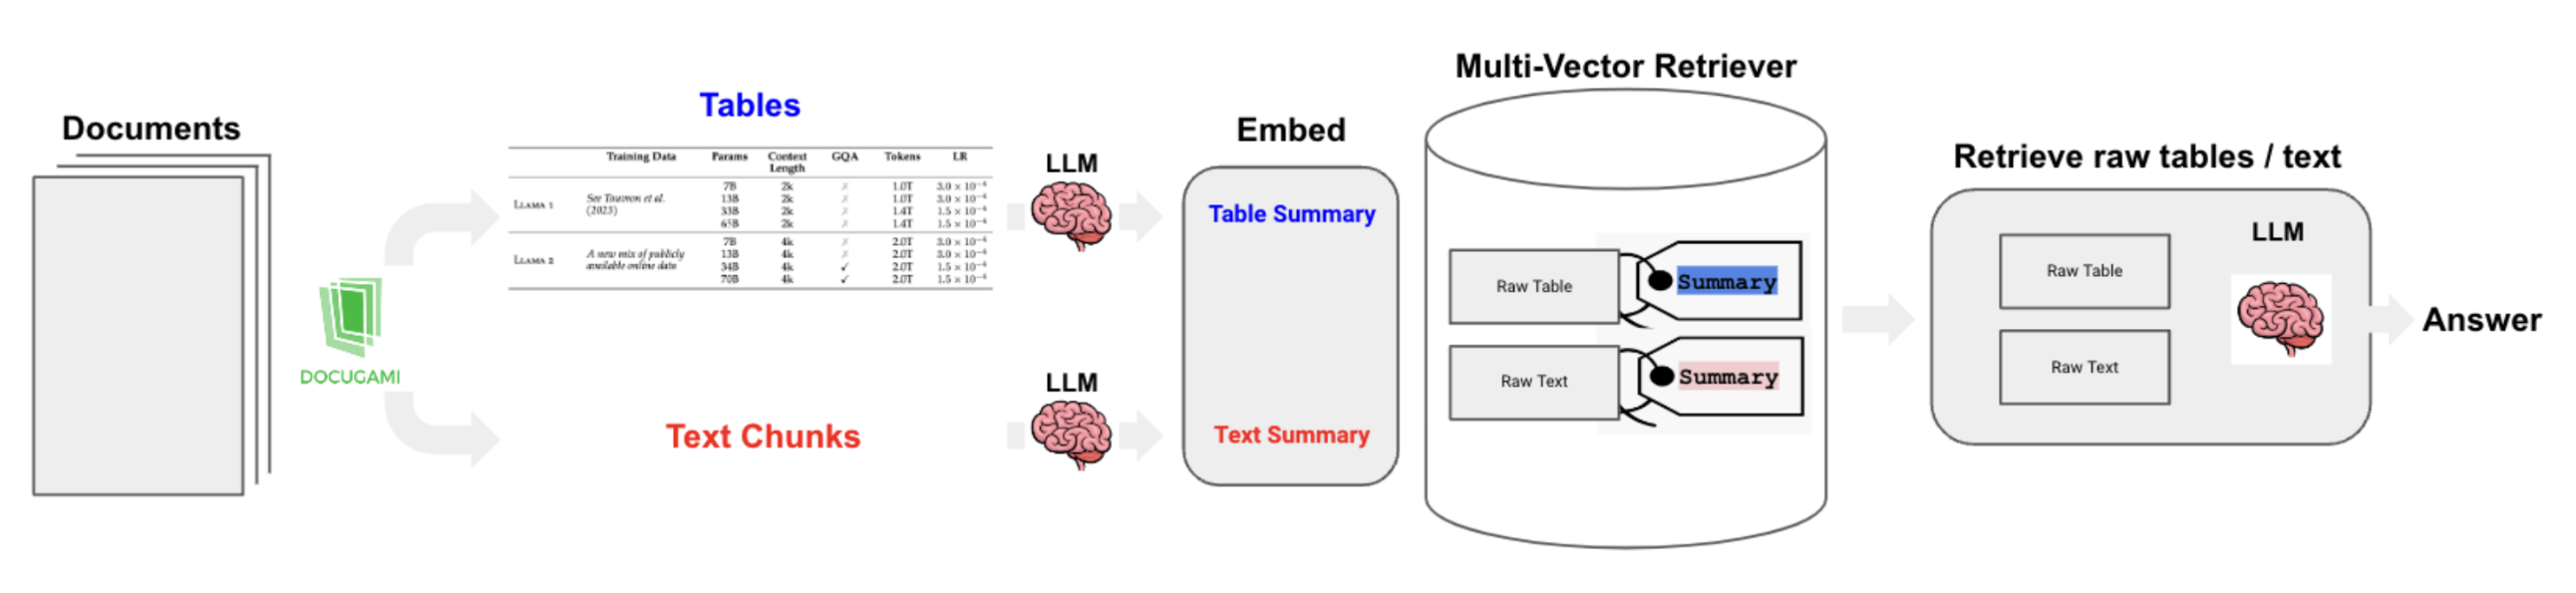

## Packages

In [16]:
! pip install langchain docugami==0.0.8 dgml-utils==0.3.0 pydantic langchainhub chromadb hnswlib --upgrade --quiet

Docugami processes documents in the cloud, so you don't need to install any additional local dependencies. 

## Data Loading

Let's use Docugami to process some documents. Here's what you need to get started:

1. Create a [Docugami workspace](http://www.docugami.com) (free trials available)
1. Create an access token via the Developer Playground for your workspace. [Detailed instructions](https://help.docugami.com/home/docugami-api).
1. Add your documents (PDF \[scanned or digital\], DOC or DOCX) to Docugami for processing. There are two ways to do this:
    1. Use the simple Docugami web experience. [Detailed instructions](https://help.docugami.com/home/adding-documents).
    1. Use the [Docugami API](https://api-docs.docugami.com), specifically the [documents](https://api-docs.docugami.com/#tag/documents/operation/upload-document) endpoint. You can also use the [docugami python library](https://pypi.org/project/docugami/) as a convenient wrapper.

Once your documents are in Docugami, they are processed and organized into sets of similar documents, e.g. NDAs, Lease Agreements, and Service Agreements. Docugami is not limited to any particular types of documents, and the clusters created depend on your particular documents. You can [change the docset assignments](https://help.docugami.com/home/working-with-the-doc-sets-view) later if you wish. You can monitor file status in the simple Docugami webapp, or use a [webhook](https://api-docs.docugami.com/#tag/webhooks) to be informed when your documents are done processing.

You can also use the [Docugami API](https://api-docs.docugami.com) or the  [docugami](https://pypi.org/project/docugami/) python library to do all the file processing without visiting the Docugami webapp except to get the API key.

> You can get an API key as documented here: https://help.docugami.com/home/docugami-api. This following code assumes you have set the `DOCUGAMI_API_TOKEN` environment variable.

First, let's define two simple helper methods to upload files and wait for them to finish processing.

In [3]:
from pprint import pprint

from docugami import Docugami
from docugami.lib.upload import upload_to_named_docset, wait_for_dgml

#### START DOCSET INFO (please change this values as needed)
DOCSET_NAME = "NTSB Aviation Incident Reports"
FILE_PATHS = [
    "/Users/tjaffri/ntsb/Report_CEN23LA277_192541.pdf",
    "/Users/tjaffri/ntsb/Report_CEN23LA338_192753.pdf",
    "/Users/tjaffri/ntsb/Report_CEN23LA363_192876.pdf",
    "/Users/tjaffri/ntsb/Report_CEN23LA394_192995.pdf",
    "/Users/tjaffri/ntsb/Report_ERA23LA114_106615.pdf",
    "/Users/tjaffri/ntsb/Report_WPR23LA254_192532.pdf",
]

# Note: Please specify ~6 (or more!) similar files to process together as a document set
#       This is currently a requirement for Docugami to automatically detect motifs
#       across the document set to generate a semantic XML Knowledge Graph.
assert len(FILE_PATHS) > 5, "Please provide at least 6 files"
#### END DOCSET INFO

dg_client = Docugami()
dg_docs = upload_to_named_docset(dg_client, FILE_PATHS, DOCSET_NAME)
dgml_paths = wait_for_dgml(dg_client, dg_docs)

pprint(dgml_paths)

{'Report_CEN23LA277_192541.pdf': '/tmp/tmpa0c77x46',
 'Report_CEN23LA338_192753.pdf': '/tmp/tmpaftfld2w',
 'Report_CEN23LA363_192876.pdf': '/tmp/tmpn7gp6be2',
 'Report_CEN23LA394_192995.pdf': '/tmp/tmp9udymprf',
 'Report_ERA23LA114_106615.pdf': '/tmp/tmpxdjbh4r_',
 'Report_WPR23LA254_192532.pdf': '/tmp/tmpz6h75a0h'}


If you are on the free Docugami tier, your files should be done in ~15 minutes or less depending on the number of pages uploaded and available resources (please contact Docugami for paid plans for faster processing). You can re-run the code above without reprocessing your files to continue waiting if your notebook is not continuously running (it does not re-upload).

### Partition PDF tables and text

You can use the [Docugami Loader](https://python.langchain.com/docs/integrations/document_loaders/docugami) to very easily get chunks for your documents, including semantic and structural metadata. This is the simpler and recommended approach for most use cases but in this notebook let's explore using the `dgml-utils` library to explore the segmented output for this file in more detail by processing the XML we just downloaded above.

In [4]:
from pathlib import Path

from dgml_utils.segmentation import get_chunks_str

# Here we just read the first file, you can do the same for others
dgml_path = dgml_paths[Path(FILE_PATHS[0]).name]

with open(dgml_path, "r") as file:
    contents = file.read().encode("utf-8")

    chunks = get_chunks_str(
        contents,
        include_xml_tags=True,  # Ensures Docugami XML semantic tags are included in the chunked output (set to False for text-only chunks and tables as Markdown)
        max_text_length=1024 * 8,  # 8k chars are ~2k tokens for OpenAI.
        # Ref: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
    )

    print(f"found {len(chunks)} chunks, here are the first few")
    for chunk in chunks[:10]:
        print(chunk.text)

found 30 chunks, here are the first few
<AviationInvestigationFinalReport-section>Aviation </AviationInvestigationFinalReport-section>Investigation Final Report
<table><tbody><tr><td>Location: </td> <td><Location><TownName>Elbert</TownName>, <USState>Colorado </USState></Location></td> <td>Accident Number: </td> <td><AccidentNumber>CEN23LA277 </AccidentNumber></td></tr> <tr><td><LocationDateTime>Date &amp; Time: </LocationDateTime></td> <td><DateTime><EventDate>June 26, 2023</EventDate>, <EventTime>11:00 Local </EventTime></DateTime></td> <td><DateTimeAccidentNumber>Registration: </DateTimeAccidentNumber></td> <td><Registration>N23161 </Registration></td></tr> <tr><td><LocationAircraft>Aircraft: </LocationAircraft></td> <td><AircraftType>Piper <AircraftType>J3C-50 </AircraftType></AircraftType></td> <td><AircraftAccidentNumber>Aircraft Damage: </AircraftAccidentNumber></td> <td><AircraftDamage>Substantial </AircraftDamage></td></tr> <tr><td><LocationDefiningEvent>Defining Event: </Loca

The file processed by Docugami in the example above was [this one](https://data.ntsb.gov/carol-repgen/api/Aviation/ReportMain/GenerateNewestReport/192541/pdf) from the NTSB and you can look at the PDF side by side to compare the XML chunks above. 

If you want text based chunks instead, Docugami also supports those and renders tables as markdown:

In [5]:
with open(dgml_path, "r") as file:
    contents = file.read().encode("utf-8")

    chunks = get_chunks_str(
        contents,
        include_xml_tags=False,  # text-only chunks and tables as Markdown
        max_text_length=1024
        * 8,  # 8k chars are ~2k tokens for OpenAI. Ref: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
    )

    print(f"found {len(chunks)} chunks, here are the first few")
    for chunk in chunks[:10]:
        print(chunk.text)

found 30 chunks, here are the first few
Aviation Investigation Final Report
+-------------------------+---------------------------------------+-------------------+-------------+
| Location:               | Elbert , Colorado                     | Accident Number:  | CEN23LA277  |
+-------------------------+---------------------------------------+-------------------+-------------+
| Date & Time:            | June 26, 2023 , 11:00 Local           | Registration:     | N23161      |
+-------------------------+---------------------------------------+-------------------+-------------+
| Aircraft:               | Piper J3C-50                          | Aircraft Damage : | Substantial |
+-------------------------+---------------------------------------+-------------------+-------------+
| Defining Event:         | Nose over/nose down                   | Injuries:         | 1 Minor     |
+-------------------------+---------------------------------------+-------------------+-------------+
| Flig

## Docugami XML Deep Dive: Jane Doe NDA Example

Let's explore the Docugami XML output for a different example PDF file (a long form contract): [Jane Doe NDA](https://github.com/docugami/dgml-utils/blob/main/python/tests/test_data/article/Jane%20Doe%20NDA.pdf). We have provided processed Docugami XML output for this PDF here: https://github.com/docugami/dgml-utils/blob/main/python/tests/test_data/article/Jane%20Doe.xml so you can follow along without processing your own documents.

In [6]:
import requests

# Download XML from known URL
dgml = requests.get(
    "https://raw.githubusercontent.com/docugami/dgml-utils/main/python/tests/test_data/article/Jane%20Doe.xml"
).text
chunks = get_chunks_str(dgml, include_xml_tags=True)
len(chunks)

39

In [7]:
# Count all the different structure categories
category_counts = {}

for element in chunks:
    category = element.structure
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

category_counts

{'h1': 9, 'div': 12, 'p': 3, 'lim h1': 9, 'lim': 1, 'table': 1, 'h1 div': 4}

In [8]:
# Tables
table_elements = [c for c in chunks if "table" in c.structure.split()]
print(f"There are {len(table_elements)} tables")

# Text
text_elements = [c for c in chunks if "table" not in c.structure.split()]
print(f"There are {len(text_elements)} text elements")

There are 1 tables
There are 38 text elements


The Docugami XML contains extremely detailed semantics and visual bounding boxes for all elements. The `dgml-utils` library parses text and non-text elements into formats appropriate to pass into LLMs (chunked text with XML semantic labels)

In [9]:
for element in text_elements[:20]:
    print(element.text)

NON-DISCLOSURE AGREEMENT
<MUTUALNON-DISCLOSUREAGREEMENT> This Non-Disclosure Agreement ("Agreement") is entered into as of <EffectiveDate>November 4, 2023 </EffectiveDate>("Effective Date"), by and between: </MUTUALNON-DISCLOSUREAGREEMENT>
Disclosing Party:
<DisclosingParty><PrincipalPlaceofBusiness>Widget Corp.</PrincipalPlaceofBusiness>, a <USState>Delaware </USState>corporation with its principal place of business at <PrincipalPlaceofBusiness><PrincipalPlaceofBusiness> <WidgetCorpAddress>123 </WidgetCorpAddress> <PrincipalPlaceofBusiness>Innovation Drive</PrincipalPlaceofBusiness> </PrincipalPlaceofBusiness> , <PrincipalPlaceofBusiness>Techville</PrincipalPlaceofBusiness>, <USState> Delaware</USState>, <PrincipalPlaceofBusiness>12345 </PrincipalPlaceofBusiness></PrincipalPlaceofBusiness> ("<Org> <CompanyName>Widget </CompanyName> <CorporateName>Corp.</CorporateName> </Org>") </DisclosingParty>
Receiving Party:
<RecipientName>Jane Doe</RecipientName>, an individual residing at <Recip

In [10]:
print(table_elements[0].text)

<table> <tbody> <tr> <td> Authorized Individual </td> <td> Role </td> <td>Purpose of Disclosure </td> </tr> <tr> <td> <AuthorizedIndividualJohnSmith> <Name>John Smith </Name> </AuthorizedIndividualJohnSmith> </td> <td> <JohnSmithRole> <ProjectManagerName>Project Manager </ProjectManagerName> </JohnSmithRole> </td> <td> <JohnSmithPurposeofDisclosure> Oversee project to which the NDA relates </JohnSmithPurposeofDisclosure> </td> </tr> <tr> <td> <AuthorizedIndividualLisaWhite> <Author>Lisa White </Author> </AuthorizedIndividualLisaWhite> </td> <td> <LisaWhiteRole> Lead Developer </LisaWhiteRole> </td> <td> <LisaWhitePurposeofDisclosure>Software development and analysis </LisaWhitePurposeofDisclosure> </td> </tr> <tr> <td> <AuthorizedIndividualMichaelBrown> <Name>Michael Brown </Name> </AuthorizedIndividualMichaelBrown> </td> <td> <MichaelBrownRole> Financial <FinancialAnalyst> Analyst </FinancialAnalyst> </MichaelBrownRole> </td> <td> <MichaelBrownPurposeofDisclosure>Financial analysis an

The XML markup contains structural as well as semantic tags, which provide additional semantics to the LLM for improved retrieval and generation.

If you prefer, you can set `include_xml_tags=False` in the `get_chunks_str` call above to not include XML markup. The text-only Docugami chunks are still very good since they follow the structural and semantic contours of the document rather than whitespace-only chunking. Tables are rendered as markdown in this case, so that some structural context is maintained even without the XML markup.

In [11]:
chunks_as_text = get_chunks_str(dgml, include_xml_tags=False)
table_elements_as_text = [c for c in chunks_as_text if "table" in c.structure.split()]

print(table_elements_as_text[0].text)

+-----------------------+-------------------+------------------------------------------+
| Authorized Individual | Role              | Purpose of Disclosure                    |
+-----------------------+-------------------+------------------------------------------+
| John Smith            | Project Manager   | Oversee project to which the NDA relates |
+-----------------------+-------------------+------------------------------------------+
| Lisa White            | Lead Developer    | Software development and analysis        |
+-----------------------+-------------------+------------------------------------------+
| Michael Brown         | Financial Analyst | Financial analysis and reporting         |
+-----------------------+-------------------+------------------------------------------+


## Multi-vector retriever

Use [multi-vector-retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) to produce summaries of tables and, optionally, text. 

With the summary, we will also store the raw table elements.

The summaries are used to improve the quality of retrieval, [as explained in the multi vector retriever docs](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector).

The raw tables are passed to the LLM, providing the full table context for the LLM to generate the answer.  

### Summaries

In [12]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)
from langchain_core.output_parsers import StrOutputParser

We create a simple summarize chain for each element.

You can also see, re-use, or modify the prompt in the Hub [here](https://smith.langchain.com/hub/rlm/multi-vector-retriever-summarization).

```
from langchain import hub
obj = hub.pull("rlm/multi-vector-retriever-summarization")
```

In [13]:
# Prompt
prompt_text = """You are an assistant tasked with summarizing tables and text. \ 
Give a concise summary of the table or text. Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatOpenAI(temperature=0, model="gpt-4")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [14]:
# Apply summarizer to tables
tables = [i.text for i in table_elements]
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

### Add to vectorstore

Use [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) with summaries: 

* `InMemoryStore` stores the raw text, tables
* `vectorstore` stores the embedded summaries

In [17]:
import uuid

from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain.vectorstores.chroma import Chroma
from langchain_core.documents import Document


def build_retriever(text_elements, tables, table_summaries):
    # The vectorstore to use to index the child chunks
    vectorstore = Chroma(
        collection_name="summaries", embedding_function=OpenAIEmbeddings()
    )

    # The storage layer for the parent documents
    store = InMemoryStore()
    id_key = "doc_id"

    # The retriever (empty to start)
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Add texts
    texts = [i.text for i in text_elements]
    doc_ids = [str(uuid.uuid4()) for _ in texts]
    retriever.docstore.mset(list(zip(doc_ids, texts)))

    # Add tables and summaries
    table_ids = [str(uuid.uuid4()) for _ in tables]
    summary_tables = [
        Document(page_content=s, metadata={id_key: table_ids[i]})
        for i, s in enumerate(table_summaries)
    ]
    retriever.vectorstore.add_documents(summary_tables)
    retriever.docstore.mset(list(zip(table_ids, tables)))
    return retriever


retriever = build_retriever(text_elements, tables, table_summaries)

## RAG

Run [RAG pipeline](https://python.langchain.com/docs/expression_language/cookbook/retrieval).

In [18]:
from langchain_core.runnables import RunnablePassthrough

system_prompt = SystemMessagePromptTemplate.from_template(
    "You are a helpful assistant that answers questions based on provided context. Your provided context can include text or tables, "
    "and may also contain semantic XML markup. Pay attention the semantic XML markup to understand more about the context semantics as "
    "well as structure (e.g. lists and tabular layouts expressed with HTML-like tags)"
)

human_prompt = HumanMessagePromptTemplate.from_template(
    """Context:

    {context}

    Question: {question}"""
)


def build_chain(retriever, model):
    prompt = ChatPromptTemplate.from_messages([system_prompt, human_prompt])

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4")

    # RAG pipeline
    chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )

    return chain


chain = build_chain(retriever, model)

In [19]:
result = chain.invoke(
    "Name all the people authorized to receive confidential information, and their roles"
)
print(result)

Number of requested results 4 is greater than number of elements in index 1, updating n_results = 1


The people authorized to receive confidential information and their roles are:

1. John Smith - Project Manager
2. Lisa White - Lead Developer
3. Michael Brown - Financial Analyst


We can check the [trace](https://smith.langchain.com/public/21b3aa16-4ef3-40c3-92f6-3f0ceab2aedb/r) to see what chunks were retrieved.

This includes Table 1 in the doc, showing the disclosures table as XML markup (same one as above)

# RAG on Llama2 paper

Let's run the same Llama2 paper example from the [Semi_Structured_RAG.ipynb](./Semi_Structured_RAG.ipynb) notebook to see if we get the same results, and to contrast the table chunk returned by Docugami with the ones returned from Unstructured.

In [20]:
dgml = requests.get(
    "https://raw.githubusercontent.com/docugami/dgml-utils/main/python/tests/test_data/arxiv/2307.09288.xml"
).text
llama2_chunks = get_chunks_str(dgml, include_xml_tags=True)
len(llama2_chunks)

669

In [21]:
# Tables
llama2_table_elements = [c for c in llama2_chunks if "table" in c.structure.split()]
print(f"There are {len(llama2_table_elements)} tables")

# Text
llama2_text_elements = [c for c in llama2_chunks if "table" not in c.structure.split()]
print(f"There are {len(llama2_text_elements)} text elements")

There are 33 tables
There are 636 text elements


In [22]:
# Apply summarizer to tables
llama2_tables = [i.text for i in llama2_table_elements]
llama2_table_summaries = summarize_chain.batch(llama2_tables, {"max_concurrency": 5})

In [23]:
llama2_retriever = build_retriever(
    llama2_text_elements, llama2_tables, llama2_table_summaries
)

In [24]:
llama2_chain = build_chain(llama2_retriever, model)

In [25]:
llama2_chain.invoke("What is the number of training tokens for LLaMA2?")

'The number of training tokens for LLaMA2 is 2.0T for all parameter sizes.'

We can check the [trace](https://smith.langchain.com/public/5de100c3-bb40-4234-bf02-64bc708686a1/r) to see what chunks were retrieved.

This includes Table 1 in the doc, showing the tokens used for training table as semantic XML markup:

```xml
<table>
    <tbody>
        <tr>
            <td />
            <td>Training Data </td>
            <td>Params </td>
            <td>Context Length </td>
            <td>
                <Org>GQA </Org>
            </td>
            <td>Tokens </td>
            <td>LR </td>
        </tr>
        <tr>
            <td>Llama <Number>1 </Number></td>
            <td>
                <Llama1TrainingData>See <Person>Touvron </Person>et al. (<Number>2023</Number>) </Llama1TrainingData>
            </td>
            <td>
                <Llama1Params>
                    <Number>7B </Number>
                    <Number>13B </Number>
                    <Number>33B </Number>
                    <Number>65B </Number>
                </Llama1Params>
            </td>
            <td>
                <Llama1ContextLength>
                    <Number>2k </Number>
                    <Number>2k </Number>
                    <Number>2k </Number>
                    <Number>2k </Number>
                </Llama1ContextLength>
            </td>
            <td>
                <Llama1GQA>✗ ✗ ✗ ✗ </Llama1GQA>
            </td>
            <td>
                <Llama1Tokens><Number>1.0</Number>T <Number>1.0</Number>T <Number>1.4</Number>T <Number>
                    1.4</Number>T </Llama1Tokens>
            </td>
            <td>
                <Llama1LR> 3.0 × <Number>10−4 </Number> 3.0 × <Number>10−4 </Number> 1.5 × <Number>
                    10−4 </Number> 1.5 × <Number>10−4 </Number></Llama1LR>
            </td>
        </tr>
        <tr>
            <td>Llama <Number>2 </Number></td>
            <td>
                <Llama2TrainingData>A new mix of publicly available online data </Llama2TrainingData>
            </td>
            <td>
                <Llama2Params><Number>7B </Number>13B <Number>34B </Number><Number>70B </Number></Llama2Params>
            </td>
            <td>
                <Llama2ContextLength>
                    <Number>4k </Number>
                    <Number>4k </Number>
                    <Number>4k </Number>
                    <Number>4k </Number>
                </Llama2ContextLength>
            </td>
            <td>
                <Llama2GQA>✗ ✗ ✓ ✓ </Llama2GQA>
            </td>
            <td>
                <Llama2Tokens><Number>2.0</Number>T <Number>2.0</Number>T <Number>2.0</Number>T <Number>
                    2.0</Number>T </Llama2Tokens>
            </td>
            <td>
                <Llama2LR> 3.0 × <Number>10−4 </Number> 3.0 × <Number>10−4 </Number> 1.5 × <Number>
                    10−4 </Number> 1.5 × <Number>10−4 </Number></Llama2LR>
            </td>
        </tr>
    </tbody>
</table>
```

Finally, you can ask other questions that rely on more subtle parsing of the table, e.g.:

In [26]:
llama2_chain.invoke("What was the learning rate for LLaMA2?")

'The learning rate for LLaMA2 was 3.0 × 10−4 for the 7B and 13B models, and 1.5 × 10−4 for the 34B and 70B models.'

## Docugami KG-RAG Template

Docugami also provides a [langchain template](https://github.com/docugami/langchain-template-docugami-kg-rag) that you can integrate into your langchain projects.

Here's a walkthrough of how you can do this.

[![Docugami KG-RAG Walkthrough](https://img.youtube.com/vi/xOHOmL1NFMg/0.jpg)](https://www.youtube.com/watch?v=xOHOmL1NFMg)
